In [117]:
import torch
from math import sqrt
from simple_fem import get_cantilever
import matplotlib.pyplot as plt

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True

torch.set_default_dtype(torch.double)

## Define a 2D cantilever beam

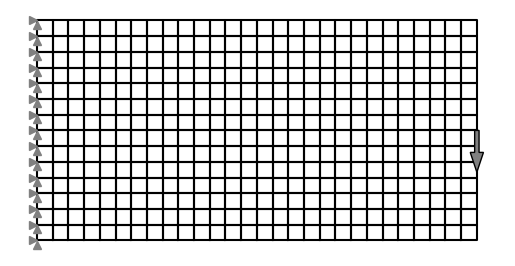

In [118]:
# Dimensions
cantilever = get_cantilever(1.0, 28.0, 14.0)
cantilever.plot()

## Optimization

In [119]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
    return x

In [120]:
def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    f_k = func(x_k)

    def approximation(x):
        res = f_k * torch.ones_like(x[..., 0])
        for j, grad in enumerate(grads):
            if grad < 0.0:
                p = 0
                q = -((x_k[j] - L_k[j]) ** 2) * grad
            else:
                p = (U_k[j] - x_k[j]) ** 2 * grad
                q = 0
            res -= p / (U_k[j] - x_k[j]) + q / (x_k[j] - L_k[j])
            res += p / (U_k[j] - x[..., j]) + q / (x[..., j] - L_k[j])
        return res

    return approximation, grads

In [121]:
def morph(fem, mask, phi, x):
    # Morph the mesh at masked positions with radial basis function
    nodes = torch.argwhere(mask)[:, 0]
    dirs = torch.argwhere(mask)[:, 1]
    M = phi[:, nodes]
    M = M[nodes, :]
    weights = torch.linalg.solve(M, x - fem.nodes[mask])
    for weight, node, dir in zip(weights, nodes, dirs):
        fem.nodes[:, dir] += weight * phi[node, :]

In [122]:
def optimize(fem, x_0, x_min, x_max, V_0, mask, iter, morph_mesh=True):
    s = 0.7

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]

    # Define the initial value, lower bound, and upper bound of "mu"
    mu_0 = torch.tensor([0.01])
    mu_lower = torch.tensor([1e-10])
    mu_upper = torch.tensor([100.0])

    # Precompute radial basis functions for morphing
    epsilon = 0.1
    r = torch.cdist(cantilever.nodes, cantilever.nodes)
    phi = torch.exp(-((epsilon * r) ** 2))

    def f(x):
        # Update nodes
        if morph_mesh:
            morph(fem, mask, phi, x)
        else:
            fem.nodes[mask] = x.reshape(fem.nodes[mask].shape)
        # Solve fem with updated nodes
        u_k, f_k = fem.solve()
        # Return compliance
        return torch.inner(f_k.ravel(), u_k.ravel())

    def g(x):
        # Update nodes
        fem.nodes[mask] = x.reshape(fem.nodes[mask].shape)
        # Return constraint function
        return torch.inner(fem.thickness, fem.areas()) - V_0

    for k in range(iter):
        # Update asymptotes with heuristic procedure (see Exercise 04)
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde, f_grad = MMA(f, x[k], L[k], U[k])
        g_tilde, g_grad = MMA(g, x[k], L[k], U[k])

        # Define the Lagrangian
        def lagrangian(x, mu):
            return f_tilde(x) + mu * g_tilde(x)

        # Define x_star by minimizing the Lagrangian w. r. t. x analytically
        def x_star(mu):
            x_hat = torch.zeros_like(f_grad)
            for i, (dfdx, dgdx) in enumerate(zip(f_grad, g_grad)):
                if dfdx > 0.0 and dgdx > 0.0:
                    x_hat[i] = x_min[i]
                if dfdx < 0.0 and dgdx < 0.0:
                    x_hat[i] = x_max[i]
                if dfdx > 0.0 and dgdx < 0.0:
                    root = torch.sqrt(
                        (-mu * dgdx * (x[k][i] - L[k][i]) ** 2)
                        / (U[k][i] - x[k][i]) ** 2
                        / dfdx
                    )
                    x_hat[i] = (U[k][i] * root + L[k][i]) / (1 + root)
                if dfdx < 0.0 and dgdx > 0.0:
                    root = torch.sqrt(
                        (-mu * dgdx * (U[k][i] - x[k][i]) ** 2)
                        / (x[k][i] - L[k][i]) ** 2
                        / dfdx
                    )
                    x_hat[i] = (U[k][i] + L[k][i] * root) / (1 + root)
            return torch.max(torch.min(x_hat, x_max_k), x_min_k)

        # Define (-1 times) the dual function
        def dual_function(mu):
            return -lagrangian(x_star(mu), mu)

        # Compute the maximum of the dual function
        mu_star = box_constrained_decent(
            dual_function, mu_0, mu_lower, mu_upper, eta=0.0001
        )

        # # Plot the dual function (just for debuging)
        # mu = torch.linspace(0.0, 0.1, 50)
        # dual = [-dual_function(m) for m in mu]
        # with torch.no_grad():
        #     plt.plot(mu, dual)
        #     plt.axvline(mu_star.item(), color="black")
        #     plt.title(f"Dual function in iteration {k}")
        #     plt.show()

        # Compute current optimal point with dual solution
        x.append(x_star(mu_star))

    return x

In [123]:
# Mask only vertical degrees of freedom of upper edge
mask = torch.zeros_like(cantilever.nodes, dtype=bool)
# mask[Ny * (Nx + 1) : (Ny + 1) * (Nx + 1), 1] = True
mask[1:29, 1] = True
control_nodes = torch.argwhere(mask)[:, 0]

# Limits on design variables
x_0 = cantilever.nodes[mask].ravel()
x_min = x_0 - 2.0
x_max = x_0 + 0.5

# Thickness, area and volume of elements
V0 = torch.inner(cantilever.areas(), cantilever.thickness)

In [124]:
x_opt = optimize(cantilever, x_0, x_min, x_max, V0, mask, 10, morph_mesh=False)

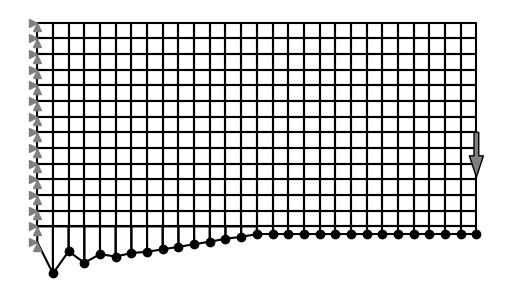

In [125]:
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0].detach(),
    cantilever.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)
plt.savefig(
    "figures/cantilever_fem_naive_shape.pdf", transparent=True, bbox_inches="tight"
)

## Morphing

In [126]:
cantilever = get_cantilever(1.0, 28.0, 14.0)

mask = torch.zeros_like(cantilever.nodes, dtype=bool)
mask[0:29:7, 1] = True
mask[14 * 29 : 15 * 29 : 7, 1] = True
control_nodes = torch.argwhere(mask)[:, 0]

x_0 = cantilever.nodes[mask].ravel()
x_min = x_0 - 0.1
x_max = x_0 + 0.1
x_min[0:5] = x_0[0:5] - 5.0
x_max[0:5] = x_0[0:5] + 5.0

# Precompute radial basis functions for morphing
r = torch.cdist(cantilever.nodes, cantilever.nodes)
phi = r
# epsilon = 0.1
# phi = torch.exp(-((epsilon * r) ** 2))

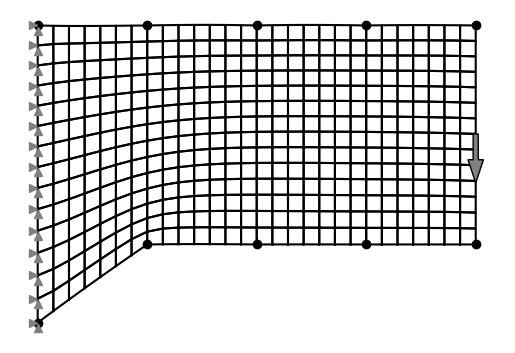

In [127]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([-5.0, 0.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "figures/cantilever_fem_shape_0_linear.pdf", transparent=True, bbox_inches="tight"
)

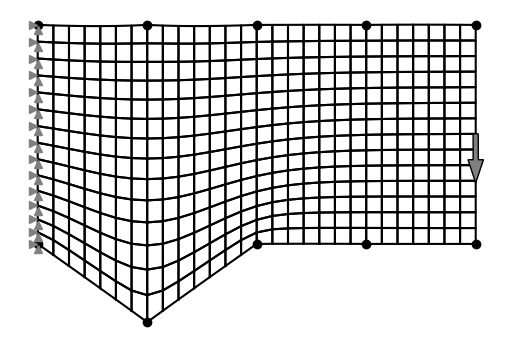

In [128]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, -5.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "figures/cantilever_fem_shape_1_linear.pdf", transparent=True, bbox_inches="tight"
)

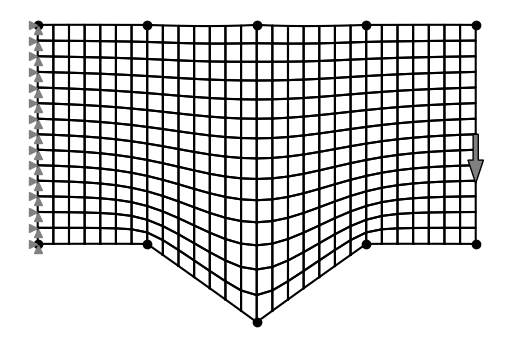

In [129]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, -5.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "figures/cantilever_fem_shape_2_linear.pdf", transparent=True, bbox_inches="tight"
)

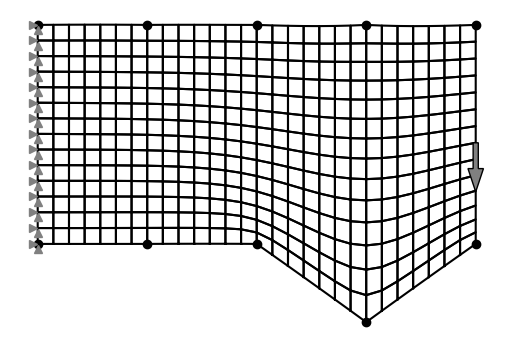

In [130]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, 0.0, -5.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "figures/cantilever_fem_shape_3_linear.pdf", transparent=True, bbox_inches="tight"
)

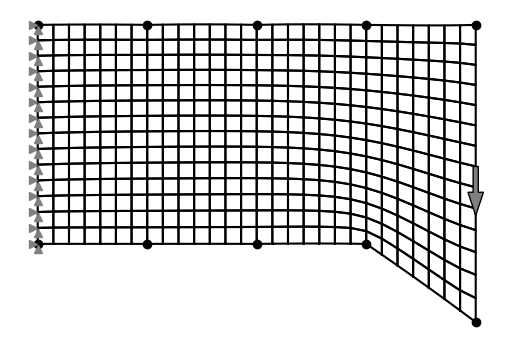

In [131]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, 0.0, 0.0, -5.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)
cantilever.plot()
plt.scatter(
    cantilever.nodes[control_nodes, 0],
    cantilever.nodes[control_nodes, 1],
    marker="o",
    color="black",
)
plt.savefig(
    "figures/cantilever_fem_shape_4_linear.pdf", transparent=True, bbox_inches="tight"
)

In [132]:
morph(
    cantilever,
    mask,
    phi,
    torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0]),
)

In [133]:
x_opt = optimize(cantilever, x_0, x_min, x_max, V0, mask, 20, morph_mesh=True)

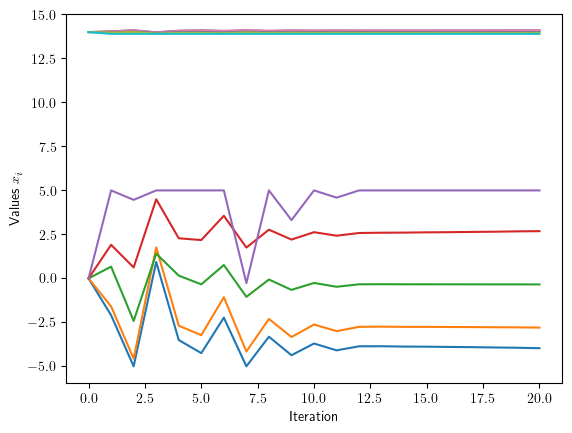

In [139]:
# Plot the development of design variables
plt.plot(torch.stack(x_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $x_i$")
plt.savefig(
    "figures/cantilever_fem_shape_variables.pdf", transparent=True, bbox_inches="tight"
)

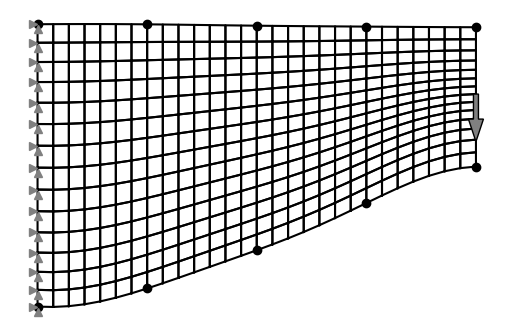

In [140]:
cantilever.plot()
plt.savefig("figures/cantilever_fem_shape.pdf", transparent=True, bbox_inches="tight")
plt.scatter(
    cantilever.nodes[control_nodes, 0].detach(),
    cantilever.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)